In [23]:
import pandas as pd
import numpy as np
from lyft_analysis.db import presto, hive, bq
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
from matplotlib.pyplot import figure
from ast import literal_eval
from keplergl import KeplerGl

In [26]:
od_pair_query = '''
SELECT r.pickup_geohash12,
       r.destination_geohash12,
       substr(r.pickup_geohash12,1,6) pickup_geohash6,
       substr(r.destination_geohash12,1,6) destination_geohash6,
       g_o.centroid pickup_geohash_center,
       g_d.centroid destination_geohash_center,
       g_o.geojson origin_geojson,
       g_d.geojson destination_geojson,
       r.pickup_lat,
       r.pickup_lng,
       r.dropoff_lat,
       r.dropoff_lng,
       r.picked_up_to_dropped_off_haversine_meters,
       r.pickup_address,
       r.destination_address,
       CASE WHEN cr.ride_id is not NULL then true else false END is_concierge,
       cr.org_id,
       tc.time_category,
       tc.time_category_rollup,
       p.post_marketing_margin,
       metatron.bookings,
       metatron.net_revenue,
       metatron.bookings_total_pax_engagement,
       metatron.primetime,
       metatron.bookings_tolls_paid,
       metatron.bookings_airport_fees_collected,
       metatron.bookings_tips_collected,
       metatron.bookings_trust_and_service_fee_collected
FROM hive.core.fact_rides r

LEFT JOIN enterprise.fact_concierge_rides cr
on cr.ride_id = r.ride_id
and cr.ds = r.ds
and cr.region = r.region

JOIN hive.default.dimension_time_category tc
  ON tc.day_of_week = extract(dow
                            FROM r.requested_at)%7
  AND tc.hour = extract(hour
                        FROM r.requested_at)
  AND tc.region = r.region
  
JOIN hive.core.fact_ride_booking_groupings metatron
  ON metatron.ride_id = r.ride_id
  
JOIN hive.core.fact_ride_pmm_groupings p
on p.ride_id = r.ride_id
  
JOIN hive.default.geohash_shapes g_o
  ON g_o.geohash = substr(r.pickup_geohash12, 1, 6)
  
JOIN hive.default.geohash_shapes g_d
  ON g_d.geohash = substr(r.destination_geohash12, 1, 6)
  
WHERE r.ds >= '2020-08-23'
  AND r.ds <= '2020-09-23'
  and p.ds >= '2020-08-23'
  and p.ds <= '2020-09-23'
  AND metatron.ds >= '2020-08-23'
  --AND cr.ds >='2020-08-05'
  AND r.region = 'BWI'
  AND r.status = 'finished'
  AND r.pickup_lat is not NULL
  AND r.pickup_lng is not NULL
  AND r.dropoff_lat is not NULL
  AND r.pickup_geohash12 is not NULL
  and r.destination_geohash12 is not NULL
'''

In [27]:
df_raw = presto.DatabaseTool().query(od_pair_query) # 2.1 GB

In [28]:
df_raw.shape

(663815, 28)

In [29]:
df = df_raw.copy()

In [30]:
# convert column types
df = df.infer_objects()
float_conversion_columns = ['post_marketing_margin', 'net_revenue', 'bookings', 'bookings_total_pax_engagement', 'primetime',
                            'bookings_tolls_paid', 'bookings_airport_fees_collected', 'bookings_tips_collected',
                            'bookings_trust_and_service_fee_collected']
df[float_conversion_columns] = df[float_conversion_columns].astype(float)

# distance quartile
df['distance_quartile'] = pd.qcut(df['picked_up_to_dropped_off_haversine_meters'], 4, labels=False)

# convert (lat, lng) to two columns
df['pickup_geohash_center'] = df['pickup_geohash_center'].apply(literal_eval)
df['pickup_geohash_center_lat'] = df['pickup_geohash_center'].apply(lambda x: x[0])
df['pickup_geohash_center_lng'] = df['pickup_geohash_center'].apply(lambda x: x[1])
df['destination_geohash_center'] = df['destination_geohash_center'].apply(literal_eval)
df['destination_geohash_center_lat'] = df['destination_geohash_center'].apply(lambda x: x[0])
df['destination_geohash_center_lng'] = df['destination_geohash_center'].apply(lambda x: x[1])

# create OD6 pair features (both ordered and unordered)
df['OD6_tuple'] = df.apply(lambda x:(x['pickup_geohash6'], x['destination_geohash6']), axis=1)
df['OD6_tuple_unordered'] = df.apply(lambda x:[x['pickup_geohash6'], x['destination_geohash6']], axis=1)
df['OD6_tuple_unordered'] = df['OD6_tuple_unordered'].apply(sorted)
df['OD6_tuple_unordered'] = df['OD6_tuple_unordered'].apply(tuple)

# create OD5 pair features (both ordered and unordered)
df['pickup_geohash5'] = df['pickup_geohash6'].apply(lambda x: x[:5])
df['destination_geohash5'] = df['destination_geohash6'].apply(lambda x: x[:5])
df['OD5_tuple'] = df.apply(lambda x:(x['pickup_geohash5'], x['destination_geohash5']), axis=1)
df['OD5_tuple_unordered'] = df.apply(lambda x:[x['pickup_geohash5'], x['destination_geohash5']], axis=1)
df['OD5_tuple_unordered'] = df['OD5_tuple_unordered'].apply(sorted)
df['OD5_tuple_unordered'] = df['OD5_tuple_unordered'].apply(tuple)

In [31]:
df.groupby('OD5_tuple_unordered')['net_revenue'].sum().sort_values(ascending=False)

OD5_tuple_unordered
(dqcx8, dqcx9)    117905.062352
(dqcx8, dqcx8)    112180.930038
(dqcrx, dqcx8)    101331.167461
(dqcx2, dqcx8)     72699.503755
(dqcx9, dqcx9)     71851.877306
                      ...      
(dqcx1, dqcxv)       -19.632379
(dr184, dr4en)       -19.852290
(dqcw8, dr4ed)       -22.923233
(dqcqp, dqcrn)       -25.714669
(dqcjq, dqcs3)       -26.522608
Name: net_revenue, Length: 9568, dtype: float64

/code/venvs/venv/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 [Text(0.0, 0, '(dqcx8, dqcx9)'),
  Text(2000.0, 0, '(dqcqk, dqcqt)'),
  Text(4000.0, 0, '(dqcjy, dqcx2)'),
  Text(6000.0, 0, '(dqcnh, dqcr4)'),
  Text(8000.0, 0, '(dqcjw, dqcmy)'),
  Text(10000.0, 0, '')])

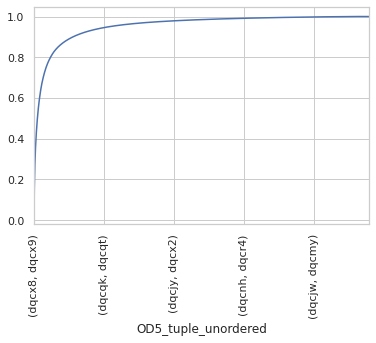

In [32]:
total_net_rev = df.net_revenue.sum()
(df.groupby('OD5_tuple_unordered')['net_revenue'].sum().sort_values(ascending=False)/total_net_rev).cumsum().plot()
plt.xticks(rotation=90)

<AxesSubplot:xlabel='picked_up_to_dropped_off_haversine_meters', ylabel='net_revenue'>

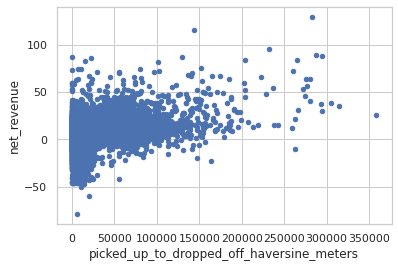

In [33]:
df.plot.scatter(x='picked_up_to_dropped_off_haversine_meters', y='net_revenue')

In [34]:
# get mapping from gh6 --> geojson
geojsons = pd.DataFrame(
    np.concatenate(
        (df[['pickup_geohash6', 'origin_geojson']],
         df[['destination_geohash6', 'destination_geojson']])
    ),
    columns = ['geohash6', 'geojson']
).drop_duplicates()

centroid_lats = pd.DataFrame(
    np.concatenate(
        (df[['pickup_geohash6', 'pickup_geohash_center_lat']],
         df[['destination_geohash6', 'destination_geohash_center_lat']])
    ),
    columns = ['geohash6', 'centroid_lat']
).drop_duplicates()

centroid_lngs = pd.DataFrame(
    np.concatenate(
        (df[['pickup_geohash6', 'pickup_geohash_center_lng']],
         df[['destination_geohash6', 'destination_geohash_center_lng']])
    ),
    columns = ['geohash6', 'centroid_lng']
).drop_duplicates()

In [37]:
# net rev by OD pair
od5_net_rev = df.groupby('OD5_tuple', as_index=False)['post_marketing_margin'].sum()
od6_net_rev = df.groupby('OD6_tuple', as_index=False)['post_marketing_margin'].sum()

# bookings by OD pair
od5_bookings = df.groupby('OD5_tuple', as_index=False)['bookings'].sum()
od6_bookings = df.groupby('OD6_tuple', as_index=False)['bookings'].sum()

In [38]:
# add geohash back to dataframes
od5_net_rev['pickup_geohash5'] = od5_net_rev['OD5_tuple'].apply(lambda x:x[0])
od5_net_rev['destination_geohash5'] = od5_net_rev['OD5_tuple'].apply(lambda x: x[1])
od6_net_rev['pickup_geohash6'] = od6_net_rev['OD6_tuple'].apply(lambda x:x[0])
od6_net_rev['destination_geohash6'] = od6_net_rev['OD6_tuple'].apply(lambda x: x[1])

In [39]:
# add geojsons back to od6 dataframe

od6_net_rev = od6_net_rev.merge(
    geojsons,
    left_on='pickup_geohash6',
    right_on='geohash6',
    suffixes=('', '_origin')
)
od6_net_rev.rename({'geojson': 'geojson_destination'}, axis=1)

od6_net_rev = od6_net_rev.merge(
    geojsons,
    left_on='destination_geohash6',
    right_on='geohash6',
    suffixes=('', '_destination')
)


# add centroids back to od6 dataframe
od6_net_rev = od6_net_rev.merge(
    centroid_lats,
    left_on='pickup_geohash6',
    right_on='geohash6',
    suffixes=('', '_origin')
)

od6_net_rev = od6_net_rev.merge(
    centroid_lngs,
    left_on='pickup_geohash6',
    right_on='geohash6',
    suffixes=('', '_origin')
)

od6_net_rev = od6_net_rev.merge(
    centroid_lats,
    left_on='destination_geohash6',
    right_on='geohash6',
    suffixes=('', '_destination')
)

od6_net_rev = od6_net_rev.merge(
    centroid_lngs,
    left_on='destination_geohash6',
    right_on='geohash6',
    suffixes=('', '_destination')
)


od6_net_rev = od6_net_rev.loc[:,~od6_net_rev.columns.duplicated()]

In [40]:
od6_net_rev['log_post_marketing_margin'] = np.log(od6_net_rev.post_marketing_margin)

/code/venvs/venv/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
map_ = KeplerGl()
map_.add_data(od6_net_rev)

In [41]:
od6_net_rev.groupby('OD6_tuple')['post_marketing_margin'].sum().sort_values(ascending=False)

OD6_tuple
(dqcx94, dqcx90)    899.593024
(dqcx94, dqcx88)    865.037534
(dqcx93, dqcx91)    790.144348
(dqcx91, dqcx90)    742.153621
(dqcx90, dqcx91)    699.318915
                       ...    
(dqcx93, dqcxbu)   -284.997223
(dqcrxu, dqcrry)   -309.458028
(dqcqy0, dqcqy2)   -323.285129
(dqcqnc, dqcv8p)   -659.096348
(dqcqnv, dqcqp5)   -681.608635
Name: post_marketing_margin, Length: 185260, dtype: float64

In [ ]:
# config = {
#   "version": "v1",
#   "config": {
#     "visState": {
#       "filters": [],
#       "layers": [
#         {
#           "id": "uhnp6qo",
#           "type": "arc",
#           "config": {
#             "dataId": "unnamed",
#             "label": "new layer",
#             "color": [
#               30,
#               150,
#               190
#             ],
#             "columns": {
#               "lat0": "centroid_lat",
#               "lng0": "centroid_lng",
#               "lat1": "centroid_lat_destination",
#               "lng1": "centroid_lng_destination"
#             },
#             "isVisible": True,
#             "visConfig": {
#               "opacity": 0.01,
#               "thickness": 1.2,
#               "colorRange": {
#                 "name": "ColorBrewer Blues-6",
#                 "type": "singlehue",
#                 "category": "ColorBrewer",
#                 "colors": [
#                   "#08519c",
#                   "#3182bd",
#                   "#6baed6",
#                   "#9ecae1",
#                   "#c6dbef",
#                   "#eff3ff"
#                 ],
#                 "reversed": True
#               },
#               "sizeRange": [
#                 0,
#                 10
#               ],
#               "targetColor": None
#             },
#             "hidden": False,
#             "textLabel": [
#               {
#                 "field": None,
#                 "color": [
#                   255,
#                   255,
#                   255
#                 ],
#                 "size": 18,
#                 "offset": [
#                   0,
#                   0
#                 ],
#                 "anchor": "start",
#                 "alignment": "center"
#               }
#             ]
#           },
#           "visualChannels": {
#             "colorField": {
#               "name": "log_net_rev",
#               "type": "real"
#             },
#             "colorScale": "quantile",
#             "sizeField": None,
#             "sizeScale": "linear"
#           }
#         }
#       ],
#       "interactionConfig": {
#         "tooltip": {
#           "fieldsToShow": {
#             "unnamed": [
#               "net_revenue",
#               "pickup_geohash6",
#               "destination_geohash6",
#               "geohash6",
#               "geohash6_destination"
#             ]
#           },
#           "enabled": True
#         },
#         "brush": {
#           "size": 0.5,
#           "enabled": False
#         },
#         "geocoder": {
#           "enabled": False
#         },
#         "coordinate": {
#           "enabled": False
#         }
#       },
#       "layerBlending": "normal",
#       "splitMaps": [],
#       "animationConfig": {
#         "currentTime": None,
#         "speed": 1
#       }
#     },
#     "mapState": {
#       "bearing": 0,
#       "dragRotate": False,
#       "latitude": 38.86909132225929,
#       "longitude": -76.51042584655063,
#       "pitch": 0,
#       "zoom": 5.402022308737961,
#       "isSplit": False
#     },
#     "mapStyle": {
#       "styleType": "dark",
#       "topLayerGroups": {},
#       "visibleLayerGroups": {
#         "label": True,
#         "road": True,
#         "border": False,
#         "building": True,
#         "water": True,
#         "land": True,
#         "3d building": False
#       },
#       "threeDBuildingColor": [
#         9.665468314072013,
#         17.18305478057247,
#         31.1442867897876
#       ],
#       "mapStyles": {}
#     }
#   }
# }
# # map_

/code/venvs/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<AxesSubplot:xlabel='post_marketing_margin'>

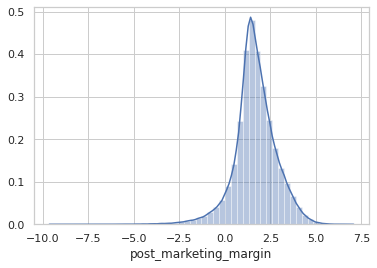

In [42]:
sns.distplot(np.log(od6_net_rev.post_marketing_margin))

In [ ]:
# table cut by origin gh6, time, and distance bucket, showing bookings, net rev, 

/code/venvs/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<AxesSubplot:xlabel='post_marketing_margin'>

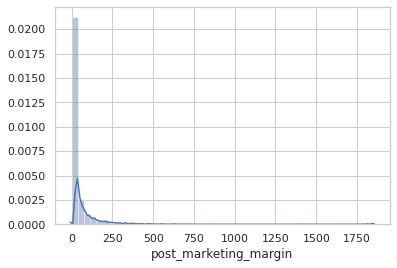

In [43]:
# origin density by ride count
sns.distplot(df.groupby(['pickup_geohash6', 'time_category'])['post_marketing_margin'].count())

/code/venvs/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<AxesSubplot:xlabel='post_marketing_margin'>

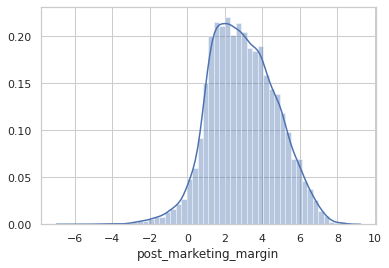

In [44]:
# origin density by log total net rev
sns.distplot(df.groupby(['pickup_geohash6', 'time_category'])['post_marketing_margin'].sum().apply(np.log))

/code/venvs/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<AxesSubplot:xlabel='bookings'>

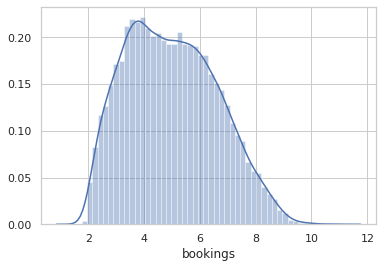

In [45]:
# origin density by log total bookings
sns.distplot(df.groupby(['pickup_geohash6', 'time_category'])['bookings'].sum().apply(np.log))

In [46]:
# net rev by distance decile
df.columns

Index(['pickup_geohash12', 'destination_geohash12', 'pickup_geohash6', 'destination_geohash6', 'pickup_geohash_center', 'destination_geohash_center', 'origin_geojson', 'destination_geojson',
       'pickup_lat', 'pickup_lng', 'dropoff_lat', 'dropoff_lng', 'picked_up_to_dropped_off_haversine_meters', 'pickup_address', 'destination_address', 'is_concierge', 'org_id', 'time_category',
       'time_category_rollup', 'post_marketing_margin', 'bookings', 'net_revenue', 'bookings_total_pax_engagement', 'primetime', 'bookings_tolls_paid', 'bookings_airport_fees_collected',
       'bookings_tips_collected', 'bookings_trust_and_service_fee_collected', 'distance_quartile', 'pickup_geohash_center_lat', 'pickup_geohash_center_lng', 'destination_geohash_center_lat',
       'destination_geohash_center_lng', 'OD6_tuple', 'OD6_tuple_unordered', 'pickup_geohash5', 'destination_geohash5', 'OD5_tuple', 'OD5_tuple_unordered'],
      dtype='object')

In [47]:
df['distance_decile'] = pd.qcut(df.picked_up_to_dropped_off_haversine_meters, 10)
df['distance_percentile'] = pd.qcut(df.picked_up_to_dropped_off_haversine_meters, 100)
df['distance_500ile'] = pd.qcut(df.picked_up_to_dropped_off_haversine_meters, 500)

/code/venvs/venv/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 [Text(0.0, 0, '(-0.001, 1279.8]'),
  Text(1.0, 0, '(1279.8, 2076.919]'),
  Text(2.0, 0, '(2076.919, 2899.352]'),
  Text(3.0, 0, '(2899.352, 3825.179]'),
  Text(4.0, 0, '(3825.179, 4899.948]'),
  Text(5.0, 0, '(4899.948, 6084.345]'),
  Text(6.0, 0, '(6084.345, 7599.492]'),
  Text(7.0, 0, '(7599.492, 9841.686]'),
  Text(8.0, 0, '(9841.686, 14022.036]'),
  Text(9.0, 0, '(14022.036, 358657.008]')])

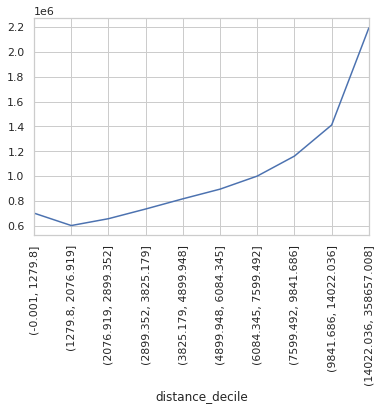

In [48]:
# total bookings by decile
ax = df.groupby('distance_decile')['bookings'].sum().plot()
plt.xticks(rotation=90)

/code/venvs/venv/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 [Text(0.0, 0, '(-0.001, 1279.8]'),
  Text(1.0, 0, '(1279.8, 2076.919]'),
  Text(2.0, 0, '(2076.919, 2899.352]'),
  Text(3.0, 0, '(2899.352, 3825.179]'),
  Text(4.0, 0, '(3825.179, 4899.948]'),
  Text(5.0, 0, '(4899.948, 6084.345]'),
  Text(6.0, 0, '(6084.345, 7599.492]'),
  Text(7.0, 0, '(7599.492, 9841.686]'),
  Text(8.0, 0, '(9841.686, 14022.036]'),
  Text(9.0, 0, '(14022.036, 358657.008]')])

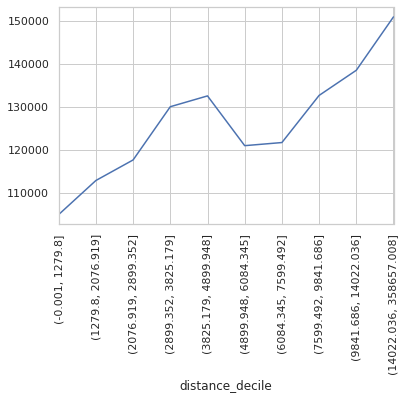

In [49]:
# total net rev by decile
ax = df.groupby('distance_decile')['post_marketing_margin'].sum().plot()
plt.xticks(rotation=90)

/code/venvs/venv/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0.0, 0, '(-0.001, 1.406]'),
  Text(100.0, 0, '(2076.919, 2091.292]'),
  Text(200.0, 0, '(3825.179, 3846.357]'),
  Text(300.0, 0, '(6084.345, 6110.496]'),
  Text(400.0, 0, '(9841.686, 9903.014]'),
  Text(500.0, 0, '')])

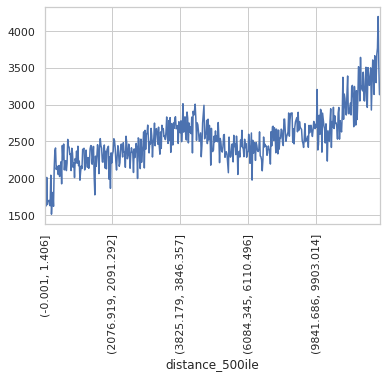

In [52]:
# total net rev by 500ile
ax = df.groupby('distance_500ile')['post_marketing_margin'].sum()[:-5].plot()
plt.xticks(rotation=90)

In [ ]:
# net rev per ride by decile
ax = (df.groupby('distance_decile')['post_marketing_margin'].sum() / df.groupby('distance_decile')['post_marketing_margin'].count()).plot()
plt.xticks(rotation=90)

In [ ]:
# net rev per ride by percentile
ax = (df.groupby('distance_percentile')['post_marketing_margin'].sum() / df.groupby('distance_percentile')['post_marketing_margin'].count()).plot()
plt.xticks(rotation=90)

In [ ]:
# bookings per ride by percentile
ax = (df.groupby('distance_percentile')['bookings'].sum() / df.groupby('distance_percentile')['bookings'].count()).plot()
plt.xticks(rotation=90)

In [22]:
map_

KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…